# Drought Event Network

a. stein 7.28.2022

Okay. So following `explore/drought_tracking.ipynb` I did `quality_control/tset_drought_event_plot.ipynb` and found that while blob identifying and connecting over time works ... the id system is a nightmare and not very smooth to use, especially as I realized during testing that I needed one extra set of parenthesis around a split to make the id's unique. This makes sorting them a further pain and there isn't a great way to trace history despite the id being unique (writing something to then process sorting is really annoying). So, let's try making a nodal network to keep track of it instead in combination with networkx.

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import xarray as xr
import rioxarray
import rasterio as rio
import pandas as pd
import geopandas as gpd

import matplotlib.dates as mdates

from tqdm.autonotebook import tqdm

import sys
sys.path.append('../../')
import ndrought.wrangle as wrangle
import ndrought.compare as compare
import ndrought.plotting as ndplot

import skimage

from skimage.color import rgb2gray
from skimage.measure import regionprops_table

Populating the interactive namespace from numpy and matplotlib


/pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/site-packages/ipykernel_launcher.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


Let's get our simpler test case up in here.

In [2]:
def tick(matrix):
    new_state = np.copy(matrix)

    i_dim, j_dim = matrix.shape

    for i in range(i_dim):
        for j in range(j_dim):
            north = matrix[i][j-1] if j>0 else 0
            south = matrix[i][j+1] if j<(j_dim-1) else 0
            west = matrix[i+1][j] if i<(i_dim-1) else 0
            east = matrix[i-1][j] if i>0 else 0
            se = matrix[i+1][j+1] if i<(i_dim-1) and j<(j_dim-1) else 0
            sw = matrix[i+1][j-1] if i<(i_dim-1) and j>0 else 0
            ne = matrix[i-1][j+1] if i>0 and j<(j_dim-1) else 0
            nw = matrix[i-1][j-1] if i>0 and j>0 else 0
            neighbors = np.sum([north, south, west, east, se, sw, ne, nw])

            # rules
            if matrix[i][j] == 0 and neighbors == 3: # reproduction
                new_state[i][j] = 1
            elif matrix[i][j] == 1 and neighbors < 2: # underpopulation
                new_state[i][j] = 0
            elif matrix[i][j] == 1 and neighbors > 3: # overpopulation
                new_state[i][j] = 0
            elif matrix[i][j] == 1 and neighbors == 2: # survives
                new_state[i][j] = 1
            elif matrix[i][j] == 1 and neighbors == 3: # also survives
                new_state[i][j] = 1

    return new_state

In [3]:
# this was originally generated randomly using the same method method as
# before, but I have now hard coded it to have a consistent test example
test_matrix = np.array([
    [0, 0, 0, 0, 0],
    [0, 1, 1, 0, 1],
    [1, 1, 0, 0, 1],
    [1, 1, 1, 0, 1],
    [0, 0, 1, 0, 1]
])

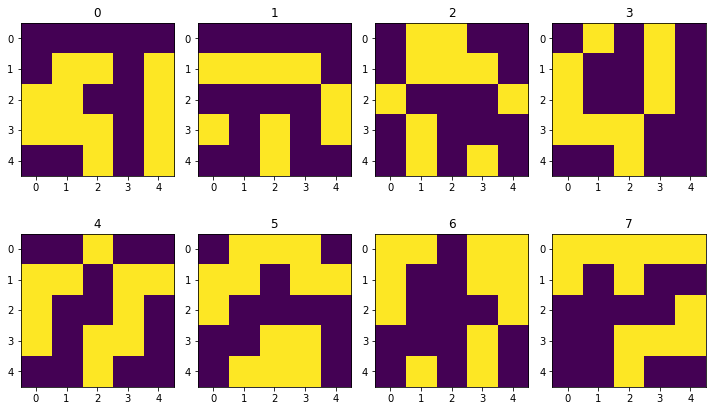

In [4]:
fig, axs = plt.subplots(2, 4, figsize=(10,6))

test_series = []
plot_matrix = test_matrix

for i, ax in enumerate(axs.ravel()):
    test_series.append(plot_matrix)
    ax.imshow(plot_matrix)
    plot_matrix = tick(plot_matrix)

    ax.set_title(i)

plt.tight_layout()

In [5]:
test_series = np.array(test_series)

In [6]:
class EventNode():

    def __init__(self, time, area, coords, event_code):
        self.time = time
        self.area = area
        self.coords = coords
        self.event_code = event_code
        self.future: List[EventNode] = list()

    def __str__(self):
        future_events = list()
        for future_EventNode in self.future:
            future_events.append(future_EventNode.event_code)
        return f'time: {self.time}, area: {self.area}, futures: {future_events}'

    def __iter__(self):
        yield self
        for node in self.future:
            yield node

    def __repr__(self):
        return f'time: {self.time}, area: {self.area}'

    def append_future(self, other):
        self.future.append(other)

    def check_connects(self, other, auto_connect=True):
        
        connection_found = False

        self_coord_set = set(tuple(coord) for coord in self.coords)
        other_coord_set = set(tuple(coord) for coord in other.coords)

        if len(self_coord_set.intersection(other_coord_set)) > 0:
            connection_found = True
            if auto_connect:
                self.append_future(other)
        
        return connection_found

Okay, I think above is a fairly good starting point for this class. I need to do the following:
- try constructing a string of `EventNode`'s and see if they match a test version
- figure out how to transition from nodes to timeseries
- figure out how to hold all the nodes for a timeseries together, given they can stop and end and may not all be connected

In [7]:
def create_EventNodes(vals:np.ndarray, time=0):
    df = wrangle.identify_drought_blob(vals)
    nodes = []
    for i in np.arange(len(df)):
        node = EventNode(
            time=time,
            area=df['area'].values[i],
            coords=df['coords'].values[i],
            event_code=''
        )
        nodes.append(node)

    # hopeful optimization
    df = None

    return nodes

In [8]:
test_nodes = [create_EventNodes(data, time=i) for i, data in enumerate(test_series)]

In [9]:
test_nodes

[[time: 0, area: 8, time: 0, area: 4],
 [time: 1, area: 6, time: 1, area: 1, time: 1, area: 2],
 [time: 2, area: 9, time: 2, area: 1],
 [time: 3, area: 10],
 [time: 4, area: 11],
 [time: 5, area: 8, time: 5, area: 5],
 [time: 6, area: 4, time: 6, area: 7, time: 6, area: 1],
 [time: 7, area: 7, time: 7, area: 5]]

In [10]:
print(test_nodes[0][0])

time: 0, area: 8, futures: []


Yay, nothing blew up.

In [11]:
for i in np.arange(len(test_nodes)-1):
    for node in test_nodes[i]:
        for potential_future in test_nodes[i+1]:
            node.check_connects(potential_future)

In [12]:
print(test_nodes[0][0])

time: 0, area: 8, futures: ['', '', '']


Does the iteration work?

In [13]:
for node in test_nodes[0][0]:
    print(node)

time: 0, area: 8, futures: ['', '', '']
time: 1, area: 6, futures: ['']
time: 1, area: 1, futures: []
time: 1, area: 2, futures: []


Nice.

That's looking promising knowing one of them does do a 3-way split. Let's get the history codes in there

I'mma be needing to make an overarching class to contain all the events and maintain an encoding scheme.

In [14]:
class DroughtNetwork:

    def __init__(self, data):
        self.data = data
        self.origins: List[EventNode] = list()

        last_nodes = []
        for i in np.arange(data.shape[0]):
            nodes_i = create_EventNodes(data[i,:,:], time=i)
            if len(nodes_i) > 0:
                if len(last_nodes) > 0:
                    for node in nodes_i:
                        for last_node in last_nodes:
                            check = last_node.check_connects(node)
                            #print(check)
                            if not check:                
                                self.origins.append(node)
                else:
                    self.origins.append(nodes_i)
                last_nodes = nodes_i
            else:
                last_nodes = []


In [15]:
drought_network = DroughtNetwork(test_series)
drought_network

In [16]:
drought_network.origins

[[time: 0, area: 8, time: 0, area: 4],
 time: 1, area: 1,
 time: 1, area: 2,
 time: 2, area: 9,
 time: 2, area: 9,
 time: 2, area: 1,
 time: 2, area: 1,
 time: 2, area: 1,
 time: 3, area: 10,
 time: 6, area: 4,
 time: 6, area: 1,
 time: 7, area: 7,
 time: 7, area: 5,
 time: 7, area: 5]

In [3]:
def identify_drought_blob(vals:np.ndarray):
    """Using sci-kit image, identify drought event blobs.

    Parameters
    ----------
    vals: np.ndarray
        Spatial values for drought data categorized
        according to the USDM scheme for a single
        time step.

    Returns
    -------
    pd.DataFrame
        Drought blobs using connectivity 2 from
        skimage.measure.label. Blobs are binary
        definitions of drought, where the measure
        exceeds D1. Each blob is provided with
        it's area, bbox, convex_area, and coordinates
        of all cells contained within the blob.    
    """

    # first we're going to make this binary
    # by setting data in a drought to 1 and
    # not in a drought to 0, including nan

    vals[(vals < 1) | np.isnan(vals)] = 0
    vals[vals > 0] = 1

    # now we are going to convert to RGBL
    (h, w) = vals.shape
    t = (h, w, 3)
    A = np.zeros(t, dtype=np.uint8)
    for i in range(h):
        for j in range(w):
            # since we already made it binary, this
            # will make 1 vals be white and 0 vals
            # be black in our RGB array
            color_val = 255*vals[i,j]
            A[i, j] = [color_val, color_val, color_val]

    # connectivity 2 will consider diagonals as connected
    blobs = skimage.measure.label(rgb2gray(A) > 0, connectivity=2)

    properties =['area', 'coords']
    df = pd.DataFrame(regionprops_table(blobs, properties=properties))
    df['drought_id'] = np.nan*np.zeros(len(df))

    return df


def connect_blobs_over_time(df_1:pd.DataFrame, df_2:pd.DataFrame):
    """Identify blobs shared between time frames.

    Parameters
    ---------
    df_1 : pd.DataFrame
        Blob dataframe at first time index.
    df_2 : pd.DataFrame
        Blob dataframe at second time index.

    Returns
    -------
    list
        Indices to each dataframe denoting which
        blobs are shared, where each tuple in the
        list is connection. The first index of
        each tuple corresponds to df_1, while the
        second index correponds to df_2
    """

    blob_pairs = []

    for idx_1, df_1_coords in enumerate(df_1.coords.values):
        df_1_coords_set = set(tuple(coord) for coord in df_1_coords)
        for idx_2, df_2_coords in enumerate(df_2.coords.values):
            df_2_coords_set = set(tuple(coord) for coord in df_2_coords)
            if len(df_1_coords_set.intersection(df_2_coords_set)) > 0:
                blob_pairs.append((idx_1, idx_2))

    return blob_pairs

def propagate_drought_id(df_1=None, df_2=None, connections=[], new_blob_num=1):

    if len(connections) > 0:

        # need to keep track of splits among multiple
        # blobs (since they are 1-to-many and we are
        # iterating through linearly)
        split_origins = dict()

        for i in np.arange(len(df_2)):
            drought_id = ""

            # ALL CONNECTIONS
            # first we need to figure out if we are connected
            connects_origins = list()
            for connect in connections:
                # this means that our current index
                # connects to a previous time's index
                if connect[1] == i:
                    # we already know it's going to index i
                    # we need to figure out where it's coming from
                    connects_origins.append(connect[0])

            # SPLITS        
            # now we need to check if this is part of a split
            split_connections = dict()
            for origin in connects_origins:
                split_counter = 0
                for connect in connections:
                    # we want to count how many times the origin is
                    # connected to something ... if it ends up being
                    # more than once then it's a split
                    if connect[0] == origin:
                        split_counter += 1
                # meaning we found a split
                if split_counter > 1:
                    split_connections[origin] = split_counter
                    # if this is a new split we found, we
                    # should make sure to save a note of it
                    if origin not in split_origins.keys():
                        split_origins[origin] = 1
                
            # so this would be if the split was found        
            if len(split_connections) > 0:
                for split_origin in split_connections.keys():
                    split_origin_id = df_1['drought_id'].values[split_origin]
                    current_split_num = split_origins[split_origin]

                    drought_id = f'({split_origin_id})-{current_split_num}'
                    
                    # iterate for the next blob it splits into
                    split_origins[split_origin] += 1

            # MERGES
            # we have a merge if more than 1 blob
            # goes into this one
            if len(connects_origins) > 1:
                merged_blob_ids = df_1.iloc[connects_origins].sort_values('area', ascending=False)['drought_id'].values
                # double check if we already had a split and began
                # writing our code for this blob, if not we need to
                # set it up
                if len(drought_id) == 0:
                    drought_id = merged_blob_ids[0]
                for id in merged_blob_ids[1:]:
                    drought_id = f'{drought_id}.({id})'
                    
            # NO SPLIT NO MERGE        
            if len(connects_origins) == 1 and len(split_connections) == 0:
                drought_id = df_1.iloc[connects_origins[0]]['drought_id']
                

            # CONNECTIONS EXIST, BUT NEW BLOB
            if len(connects_origins) == 0:
                drought_id = f'{new_blob_num}'
                new_blob_num += 1    

            df_2.loc[i, 'drought_id'] = drought_id                   

    else:
        # there were no connections, all id's start from scratch
        for i in np.arange(len(df_2)):
            df_2.loc[i, 'drought_id'] = f'{new_blob_num}'
            new_blob_num += 1

    return df_2, new_blob_num

def encode_drought_events(data:np.ndarray):
    """Detect and encode drought events.

    Parameters
    ----------
    data: np.ndarray
        Expecting first index to be temporal while second
        and third are spatial.

    Returns
    -------
    pd.DataFrame
        A multi-indexed dataframe with time as the first level
        and drought_id as the second level. 'area', 'convex_area',
        and 'coords' are also outputted in this dataframe computed 
        from sci-kit image. 
    
    """
    blob_dfs = []

    for i in tqdm(np.arange(data.shape[0]), desc='Identifying Blobs'):
        blob_dfs.append(identify_drought_blob(data[i,:,:]))
    

    #return blob_dfs

    new_blob_num = 1
    init_df, new_blob_num = propagate_drought_id(df_2=blob_dfs[0])
    init_df['time'] = 0
    encoded_blob_dfs = [init_df]    
    for i in tqdm(np.arange(len(blob_dfs)-1), desc='Encoding Blobs'):
        df_1 = encoded_blob_dfs[i]
        df_2 = blob_dfs[i+1]

        blob_pairs = connect_blobs_over_time(df_1, df_2)
        df_2_encoded, new_blob_num = propagate_drought_id(df_1, df_2, blob_pairs, new_blob_num)
        df_2_encoded['time'] = i+1
        encoded_blob_dfs.append(df_2_encoded)

    all_blobs_df = pd.concat([df[['time', 'drought_id', 'area', 'coords']] for df in encoded_blob_dfs], ignore_index=True)
    all_blobs_df = all_blobs_df.set_index(['time', 'drought_id'])
    all_blobs_df['drought_id'] = all_blobs_df.index.get_level_values(1)

    return all_blobs_df

In [4]:
dm_path = '/pool0/home/steinadi/data/drought/drought_impact/data/drought_measures'

paired_ds = xr.open_dataset(f'{dm_path}/ndrought_products/paired_USDM_SPI.nc')

In [6]:
USDM_events = encode_drought_events(paired_ds['USDM'].values)

Identifying Blobs:   0%|          | 0/1148 [00:00<?, ?it/s]

Encoding Blobs:   0%|          | 0/1147 [00:00<?, ?it/s]

In [7]:
USDM_events

area  convex_area  \
time drought_id                                               
56   1                                     653          665   
57   1                                     653          665   
58   1                                   12006        13514   
     2                                      37           65   
     3                                       1            1   
...                                        ...          ...   
1144 (((75.(76).(77.(78)))-1.(80))-1)-2      2            2   
1145 (((75.(76).(77.(78)))-1.(80))-1)-1   6861         7561   
     (((75.(76).(77.(78)))-1.(80))-1)-2      2            2   
1146 (((75.(76).(77.(78)))-1.(80))-1)-1   6771         7276   
1147 (((75.(76).(77.(78)))-1.(80))-1)-1   6810         7316   

                                                                                    coords  \
time drought_id                                                                              
56   1                                   [[0, 154], [0, 155], [0, 156], [0, 157], [0, 1...   
57   1                                   [[0, 154], [0, 155], [0, 156], [0, 157], [0, 1...   
58   1                                   [[0, 49], [0, 50], [0, 51], [0, 52], [0, 53], ...   
     2                                   [[6, 41], [7, 41], [7, 43], [7, 44], [7, 45], ...   
     3                                                                          [[10, 53]]   
...                                                                                    ...   
1144 (((75.(76).(77.(78)))-1.(80))-1)-2                               [[82, 62], [82, 63]]   
1145 (((75.(76).(77.(78)))-1.(80))-1)-1  [[0, 113], [0, 114], [0, 115], [0, 116], [0, 1...   
     (((75.(76).(77.(78)))-1.(80))-1)-2                               [[82, 62], [82, 63]]   
1146 (((75.(76).(77.(78)))-1.(80))-1)-1  [[0, 114], [0, 115], [0, 116], [0, 117], [0, 1...   
1147 (((75.(76).(77.(78)))-1.(80))-1)-1  [[0, 113], [0, 114], [0, 115], [0, 116], [0, 1...   

                                                                 drought_id  
time drought_id                                                              
56   1                                                                    1  
57   1                                                                    1  
58   1                                                                    1  
     2                                                                    2  
     3                                                                    3  
...                                                                     ...  
1144 (((75.(76).(77.(78)))-1.(80))-1)-2  (((75.(76).(77.(78)))-1.(80))-1)-2  
1145 (((75.(76).(77.(78)))-1.(80))-1)-1  (((75.(76).(77.(78)))-1.(80))-1)-1  
     (((75.(76).(77.(78)))-1.(80))-1)-2  (((75.(76).(77.(78)))-1.(80))-1)-2  
1146 (((75.(76).(77.(78)))-1.(80))-1)-1  (((75.(76).(77.(78)))-1.(80))-1)-1  
1147 (((75.(76).(77.(78)))-1.(80))-1)-1  (((75.(76).(77.(78)))-1.(80))-1)-1  

[1408 rows x 4 columns]